# 😴 Multi-Day Sleep Analysis 💤
<p align="center">
  <img src="imgs/data_dreaming.png" alt="24-Hour Sleep Timeline EDA" width="400"/>
</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

print("✅ Imports loaded successfully")

✅ Imports loaded successfully


In [23]:
# ===== ANALYSIS MODE =====
ANALYSIS_MODE = 'single'  # 'single' or 'multi'

# ===== SINGLE DAY CONFIGURATION =====
TARGET_DATE = '2025-10-12'  # Date to analyze (YYYY-MM-DD)

# ===== MULTI-DAY CONFIGURATION =====
START_DATE = '2025-11-17'   # Start date (YYYY-MM-DD)
END_DATE = '2025-11-20'     # End date (YYYY-MM-DD)

# ===== DATA CONFIGURATION =====
PARQUET_PATH = '../data'  # Data directory
TIMEZONE = 'Europe/London'

print(f"Configuration loaded:")
print(f"  Analysis Mode: {ANALYSIS_MODE}")
if ANALYSIS_MODE == 'single':
    print(f"  Target Date: {TARGET_DATE}")
else:
    print(f"  Date Range: {START_DATE} to {END_DATE}")
print(f"  Timezone: {TIMEZONE}")

Configuration loaded:
  Analysis Mode: single
  Target Date: 2025-10-12
  Timezone: Europe/London


In [24]:
from functions.load_data import load_single_date_from_parquet, load_date_range_from_parquet

In [25]:
# Load data based on analysis mode
if ANALYSIS_MODE == 'single':
    dfs = load_single_date_from_parquet(TARGET_DATE, PARQUET_PATH, TIMEZONE)
    print(f"\n📊 Data Summary for {TARGET_DATE}:")
else:
    dfs = load_date_range_from_parquet(START_DATE, END_DATE, PARQUET_PATH, TIMEZONE)
    print(f"\n📊 Data Summary for {START_DATE} to {END_DATE}:")

print("=" * 70)
for name, df in dfs.items():
    print(f"{name:30s} | {len(df):6d} records")

print(f"\n✅ Data loaded successfully")


📊 Data Summary for 2025-10-12:
HeartRate_Intraday             |  35826 records
Steps_Intraday                 |   1440 records
SleepLevels                    |     29 records
Activity-minutesFairlyActive   |      1 records
RestingHR                      |      1 records
HR_Zones                       |      1 records
Activity-distance              |      1 records
Activity-calories              |      1 records
Activity-steps                 |      1 records
Activity-minutesVeryActive     |      1 records
Activity-minutesSedentary      |      1 records
SPO2_Daily                     |      1 records
SkinTemperature                |      1 records
BreathingRate                  |      1 records
HRV                            |      1 records
Activity-minutesLightlyActive  |      1 records
SleepSummary                   |      2 records

✅ Data loaded successfully


In [26]:
# Extract common DataFrames
# df_hr_intra = dfs.get('HeartRate_Intraday', pd.DataFrame())
df_sleep_levels = dfs.get('SleepLevels', pd.DataFrame())
df_sleep_summary = dfs.get('SleepSummary', pd.DataFrame())
df_skin_temp = dfs.get('SkinTemperature', pd.DataFrame())
df_steps_intra = dfs.get('Steps_Intraday', pd.DataFrame())
# df_breathing_rate = dfs.get('BreathingRate', pd.DataFrame())

# Convert sleep summary times to target timezone
if not df_sleep_summary.empty:
    if 'time' in df_sleep_summary.columns and pd.api.types.is_datetime64_any_dtype(df_sleep_summary['time']):
        df_sleep_summary['time'] = df_sleep_summary['time'].dt.tz_convert(TIMEZONE)
    if 'endTime' in df_sleep_summary.columns:
        df_sleep_summary['endTime'] = pd.to_datetime(df_sleep_summary['endTime']).dt.tz_convert(TIMEZONE)

# Load SpO2 data for date range (to handle multi-day sleep sessions)
# We need to load SpO2 for surrounding dates in case sleep sessions span multiple days
def load_spo2_for_date_range(target_date_str, parquet_path='../data', days_before=1, days_after=1):
    """Load SpO2 data for a date range around the target date."""
    target_date = pd.to_datetime(target_date_str)
    start_date = (target_date - pd.Timedelta(days=days_before)).strftime('%Y-%m-%d')
    end_date = (target_date + pd.Timedelta(days=days_after)).strftime('%Y-%m-%d')
    
    daily_file = Path(parquet_path) / 'daily_summaries.parquet'
    if not daily_file.exists():
        return pd.DataFrame()
    
    try:
        df = pd.read_parquet(daily_file)
        df = df[(df['measurement'] == 'SPO2_Daily') & 
                (df['date'] >= start_date) & 
                (df['date'] <= end_date)].copy()
        
        # Clean column names
        from functions.load_data import clean_column_names
        df = clean_column_names(df)
        
        return df
    except Exception as e:
        print(f"Error loading SpO2: {e}")
        return pd.DataFrame()

# Load SpO2 data for the date range
if ANALYSIS_MODE == 'single':
    df_spo2_multi = load_spo2_for_date_range(TARGET_DATE, PARQUET_PATH)
else:
    # For multi-day mode, load wider range
    start = pd.to_datetime(START_DATE)
    end = pd.to_datetime(END_DATE)
    days_range = (end - start).days + 3  # Add buffer
    df_spo2_multi = load_spo2_for_date_range(START_DATE, PARQUET_PATH, days_before=1, days_after=days_range)

# Create SpO2 lookup by date
spo2_lookup = {}
if not df_spo2_multi.empty and 'date' in df_spo2_multi.columns:
    for _, row in df_spo2_multi.iterrows():
        date_key = row['date']
        spo2_lookup[date_key] = {
            'avg': row.get('avg', None),
            'max': row.get('max', None),
            'min': row.get('min', None)
        }

In [27]:
df_skin_temp

,time,Device,value,dailyRmssd,deepRmssd,nightlyRelative,avg,max,min,Out of Range,...,Source,weight_kg,bmi,hasGps,ActivityID,lat,lon,altitude,heart_rate,date
140,2025-10-12 11:00:00+00:00,PixelWatch3,NaN,NaN,NaN,-2.3,NaN,NaN,NaN,NaN,...,None,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,2025-10-12


In [28]:
def load_skin_temp_for_date_range(target_date_str, parquet_path='../data', days_before=1, days_after=1):
    """Load SpO2 data for a date range around the target date."""
    target_date = pd.to_datetime(target_date_str)
    start_date = (target_date - pd.Timedelta(days=days_before)).strftime('%Y-%m-%d')
    end_date = (target_date + pd.Timedelta(days=days_after)).strftime('%Y-%m-%d')
    
    daily_file = Path(parquet_path) / 'daily_summaries.parquet'
    if not daily_file.exists():
        return pd.DataFrame()
    
    try:
        df = pd.read_parquet(daily_file)
        df = df[(df['measurement'] == 'SkinTemperature') & 
                (df['date'] >= start_date) & 
                (df['date'] <= end_date)].copy()
        
        # Clean column names
        from functions.load_data import clean_column_names
        df = clean_column_names(df)
        
        return df
    except Exception as e:
        print(f"Error loading SpO2: {e}")
        return pd.DataFrame()

# Load SpO2 data for the date range
if ANALYSIS_MODE == 'single':
    df_skin_temp_multi = load_skin_temp_for_date_range(TARGET_DATE, PARQUET_PATH)
else:
    # For multi-day mode, load wider range
    start = pd.to_datetime(START_DATE)
    end = pd.to_datetime(END_DATE)
    days_range = (end - start).days + 3  # Add buffer
    df_skin_temp_multi = load_skin_temp_for_date_range(START_DATE, PARQUET_PATH, days_before=1, days_after=days_range)

# Create SpO2 lookup by date
skin_temp_lookup = {}
if not df_skin_temp_multi.empty and 'date' in df_skin_temp_multi.columns:
    for _, row in df_skin_temp_multi.iterrows():
        date_key = row['date']
        skin_temp_lookup[date_key] = {
            'nightlyRelative': row.get('nightlyRelative', None)
        }

In [29]:
# Helper function to get SpO2 for a specific sleep session
def get_skin_temp_for_sleep(sleep_end_time):
    """
    Get SpO2 value for a sleep session based on wake-up date.
    
    Args:
        sleep_end_time: The end time of the sleep session (wake-up time)
    
    Returns:
        dict with 'avg', 'max', 'min' or None if not available
    """
    if sleep_end_time is None:
        return None
    
    # Convert to date string for lookup
    wake_date = sleep_end_time.date().strftime('%Y-%m-%d')
    
    # Look up SpO2 for this date
    return skin_temp_lookup.get(wake_date, None)

print(f"✅ Skin Temp lookup created with {len(skin_temp_lookup)} dates")

✅ Skin Temp lookup created with 3 dates


In [30]:
skin_temp_lookup

{'2025-10-11': {'nightlyRelative': -1.2},
 '2025-10-12': {'nightlyRelative': -2.3},
 '2025-10-13': {'nightlyRelative': 1.1}}

In [31]:
# Helper function to get SpO2 for a specific sleep session
def get_spo2_for_sleep(sleep_end_time):
    """
    Get SpO2 value for a sleep session based on wake-up date.
    
    Args:
        sleep_end_time: The end time of the sleep session (wake-up time)
    
    Returns:
        dict with 'avg', 'max', 'min' or None if not available
    """
    if sleep_end_time is None:
        return None
    
    # Convert to date string for lookup
    wake_date = sleep_end_time.date().strftime('%Y-%m-%d')
    
    # Look up SpO2 for this date
    return spo2_lookup.get(wake_date, None)

print(f"✅ SpO2 lookup created with {len(spo2_lookup)} dates")

✅ SpO2 lookup created with 3 dates


In [32]:
from functions.sleep_helpers import *

In [33]:
# Prepare sleep data (calculate end times)
if not df_sleep_levels.empty and 'duration_seconds' in df_sleep_levels.columns:
    df_sleep_levels['end_time'] = df_sleep_levels['time'] + pd.to_timedelta(df_sleep_levels['duration_seconds'], unit='s')

if not df_sleep_summary.empty and 'endTime' in df_sleep_summary.columns:
    # Convert endTime to datetime and ensure it's in the target timezone
    df_sleep_summary['end_time'] = pd.to_datetime(df_sleep_summary['endTime'])
    if df_sleep_summary['end_time'].dt.tz is not None:
        df_sleep_summary['end_time'] = df_sleep_summary['end_time'].dt.tz_convert(TIMEZONE)
    else:
        df_sleep_summary['end_time'] = df_sleep_summary['end_time'].dt.tz_localize(TIMEZONE)

if not df_sleep_levels.empty:
    df_sleep_levels['level_name'] = df_sleep_levels['level'].map(LEVEL_DECODE)

print("✅ Sleep data prepared")

✅ Sleep data prepared


In [34]:
# Sleep Overview
if not df_sleep_summary.empty:
    sleep_date = pd.to_datetime(TARGET_DATE).date()
    midnight_start = pd.Timestamp(sleep_date, tz=TIMEZONE)
    midnight_end = midnight_start + pd.Timedelta(days=1)
    
    total_asleep_today = 0
    main_sleep_today = 0
    nap_sleep_today = 0
    
    for idx, row in df_sleep_summary.sort_values('time').iterrows():
        start = row['time']
        end = row.get('end_time', start + pd.Timedelta(minutes=row['minutesAsleep'] + row.get('minutesAwake', 0)))
        is_main = row.get('isMainSleep', 'Unknown')
        
        # Ensure timezone is set (should already be converted from earlier cell)
        if start.tzinfo is None:
            start = start.tz_localize(TIMEZONE)
        else:
            start = start.tz_convert(TIMEZONE)
        
        if end.tzinfo is None:
            end = end.tz_localize(TIMEZONE)
        else:
            end = end.tz_convert(TIMEZONE)
        
        clipped_start = max(start, midnight_start)
        clipped_end = min(end, midnight_end)
        
        if clipped_end > clipped_start:
            total_duration = (end - start).total_seconds() / 60
            clipped_duration = (clipped_end - clipped_start).total_seconds() / 60
            proportion = clipped_duration / total_duration if total_duration > 0 else 0
            minutes_today = row['minutesAsleep'] * proportion
            total_asleep_today += minutes_today
            
            if is_main == 'True':
                main_sleep_today += minutes_today
            else:
                nap_sleep_today += minutes_today
    
    # Total summary header
    total_hours = int(total_asleep_today // 60)
    total_mins = int(total_asleep_today % 60)
    main_hours = int(main_sleep_today // 60)
    main_mins = int(main_sleep_today % 60)
    nap_hours = int(nap_sleep_today // 60)
    nap_mins = int(nap_sleep_today % 60)

    if ANALYSIS_MODE == 'single':
        print("=" * 60)
        print(f"📅 Sleep Date:  {sleep_date.strftime('%A, %dth %B %Y')}")
        print(f"🛏️ TOTAL SLEEP: {total_hours}h {total_mins}m")
        print(f"   🌙 Main: {main_hours}h {main_mins}m | 💤 Naps: {nap_hours}h {nap_mins}m")
        print("=" * 60)
    else:
        None
    
    for idx, row in df_sleep_summary.sort_values('time').iterrows():
        is_main = row.get('isMainSleep', 'Unknown')
        session_type = "🌙 MAIN SLEEP" if is_main == 'True' else "💤 NAP"
        
        start = row['time']
        end = row.get('end_time', start + pd.Timedelta(minutes=row['minutesAsleep'] + row.get('minutesAwake', 0)))
        
        # Ensure timezone conversion
        if start.tzinfo is not None and start.tz != TIMEZONE:
            start = start.tz_convert(TIMEZONE)
        if end.tzinfo is not None and end.tz != TIMEZONE:
            end = end.tz_convert(TIMEZONE)
        
        asleep_hr = row['minutesAsleep'] / 60
        awake_min = row.get('minutesAwake', 0)
        efficiency = row.get('efficiency', 0)
        minutes_in_bed = int(row['minutesInBed'])
        hours_in_bed = minutes_in_bed // 60
        mins_in_bed = minutes_in_bed % 60
        deep = row.get('minutesDeep', 0)
        light = row.get('minutesLight', 0)
        rem = row.get('minutesREM', 0)
        
        # Get SpO2 for this specific sleep session (based on wake-up date)
        spo2_data = get_spo2_for_sleep(end)
        if spo2_data and spo2_data['avg'] is not None:
            spo2_str = f"💨 SpO2:        {spo2_data['avg']:.1f}% (max: {spo2_data['max']:.1f}%, min: {spo2_data['min']:.1f}%)\n"
        else:
            spo2_str = "💨 SpO2:        N/A\n"

        # Get skin temp for this specific sleep session (based on wake-up date)
        skin_temp_data = get_skin_temp_for_sleep(end)
        if skin_temp_data and skin_temp_data['nightlyRelative'] is not None:
            skin_temp_str = f"🌡️ Skin Temp:   {skin_temp_data['nightlyRelative']:.1f}%\n"
        else:
            skin_temp_str = "🌡️ Skin Temp:  N/A\n"
        
        print(f"\n{session_type}")
        print("-" * 60)
        print(
            f"🕒 To Bed:      {start.strftime('%H:%M on %A %dth %B')}\n"
            f"🕓 Up & Atom:   {end.strftime('%H:%M on %A %dth %B')}\n"
            f"⏱️ Duration:    {hours_in_bed}h {mins_in_bed}m ({minutes_in_bed} min)\n"
            f"😴 Asleep:      {asleep_hr:.2f} hrs ({row['minutesAsleep']:.0f} min)\n"
            f"👁️ Awake:       {awake_min:.0f} min\n"
            f"{spo2_str}"
            f"{skin_temp_str}"
            f"⚡ Efficiency:  {efficiency:.0f}%\n"
            f"\n💤 Sleep Stages:\n"
            f"   Deep:  {deep:.0f} min ({deep/row['minutesAsleep']*100 if row['minutesAsleep'] > 0 else 0:.1f}%)\n"
            f"   Light: {light:.0f} min ({light/row['minutesAsleep']*100 if row['minutesAsleep'] > 0 else 0:.1f}%)\n"
            f"   REM:   {rem:.0f} min ({rem/row['minutesAsleep']*100 if row['minutesAsleep'] > 0 else 0:.1f}%)"
        )
        print("\n" + "=" * 60)
else:
    print("❌ No sleep summary data available")

📅 Sleep Date:  Sunday, 12th October 2025
🛏️ TOTAL SLEEP: 5h 30m
   🌙 Main: 5h 30m | 💤 Naps: 0h 0m

🌙 MAIN SLEEP
------------------------------------------------------------
🕒 To Bed:      22:38 on Saturday 11th October
🕓 Up & Atom:   05:58 on Sunday 12th October
⏱️ Duration:    7h 20m (440 min)
😴 Asleep:      6.13 hrs (368 min)
👁️ Awake:       72 min
💨 SpO2:        94.6% (max: 96.4%, min: 92.2%)
🌡️ Skin Temp:   -2.3%
⚡ Efficiency:  84%

💤 Sleep Stages:
   Deep:  41 min (11.1%)
   Light: 277 min (75.3%)
   REM:   49 min (13.3%)


🌙 MAIN SLEEP
------------------------------------------------------------
🕒 To Bed:      23:21 on Sunday 12th October
🕓 Up & Atom:   05:51 on Monday 13th October
⏱️ Duration:    6h 30m (390 min)
😴 Asleep:      5.22 hrs (313 min)
👁️ Awake:       77 min
💨 SpO2:        93.7% (max: 95.9%, min: 91.3%)
🌡️ Skin Temp:   1.1%
⚡ Efficiency:  80%

💤 Sleep Stages:
   Deep:  78 min (24.9%)
   Light: 171 min (54.6%)
   REM:   64 min (20.4%)



In [35]:
def plot_sleep_timeline(df_levels, df_summary):
    """Plot horizontal timeline showing sleep stages for a single day (28-hour window: 20:00 previous day to midnight next day)."""
    if df_levels.empty or df_summary.empty:
        print(f"❌ No sleep data found")
        return None

    main_sleep = df_summary[df_summary.get('isMainSleep', 'True') == 'True']
    if main_sleep.empty:
        main_sleep = df_summary.iloc[[0]]

    main_sleep_start = main_sleep.iloc[0]['time']
    
    main_sleep_end = (
        main_sleep.iloc[0].get("endTime") or
        main_sleep.iloc[0].get("end_time") or
        None
    )
    if main_sleep_end is not None:
        main_sleep_end = pd.to_datetime(main_sleep_end)
        # Ensure timezone is converted
        if main_sleep_end.tzinfo is not None:
            main_sleep_end = main_sleep_end.tz_convert(TIMEZONE)
        # Use the wake-up date for the window (more intuitive - "Nov 18's sleep" = woke up on Nov 18)
        actual_date = main_sleep_end.date()
    else:
        actual_date = main_sleep_start.date()

    # Use 28-hour window: 20:00 previous day to 00:00 next day
    start_time = pd.Timestamp(actual_date, tz=TIMEZONE) - pd.Timedelta(hours=3)
    end_time = start_time + pd.Timedelta(hours=27)

    print(f"   📅 Date: {actual_date.strftime('%A %dth %B %Y')}")
    # print(f"   🕐 Window: {start_time.strftime('%H:%M %a %d %b')} → {end_time.strftime('%H:%M %a %d %b')}")
    print(f"   🌙 To Bed: {main_sleep_start.strftime('%H:%M on %A %dth %B')}")
    if main_sleep_end is not None:
        print(f"   ☀️ Woke Up: {main_sleep_end.strftime('%H:%M on %A %dth %B')}\n")

    levels = prepare_sleep_data(df_levels, df_summary, start_time, end_time)
    if levels.empty:
        print(f"❌ No sleep level data found")
        return None

    fig, ax = plt.subplots(figsize=(18, 4))
    plot_sleep_bars(ax, levels)

    ax.axvline(main_sleep_start, linestyle="--", linewidth=1.2)
    ax.text(main_sleep_start, 1.05, "To Bed", ha="center", va="bottom",
            fontsize=10, transform=ax.get_xaxis_transform())

    if main_sleep_end is not None:
        ax.axvline(main_sleep_end, linestyle="--", linewidth=1.2)
        ax.text(main_sleep_end, 1.05, "Up", ha="center", va="bottom",
                fontsize=10, transform=ax.get_xaxis_transform())

    title = f'{actual_date.strftime("%A %dth %B %Y")}\n'

    format_timeline_axis(ax, start_time, end_time, title, interval_minutes=60)
    add_sleep_legend(ax, location='upper right')

    plt.tight_layout()
    return fig

In [36]:
# ============================================================================
# ACTIVITY PATTERN ANALYSIS
# ============================================================================

def plot_hourly_activity_heatmap(df_steps_intra, tz='Europe/London'):
    """
    Show hourly activity levels as a heatmap-style bar chart.
    
    Args:
        df_steps_intra: Intraday steps DataFrame
        tz: Timezone for display
    
    Returns:
        matplotlib.figure.Figure: The generated figure
    """
    if df_steps_intra.empty:
        print("⚠️  No steps data available")
        return None
    
    # Convert to local timezone
    df_steps = df_steps_intra.copy()
    if df_steps['time'].dt.tz is not None:
        df_steps['time'] = df_steps['time'].dt.tz_convert(tz)
    
    # Extract date and hour
    date_str = df_steps['time'].iloc[0].strftime('%A, %dth %B')
    df_steps['hour'] = df_steps['time'].dt.hour
    
    # Calculate steps per hour
    hourly_steps = df_steps.groupby('hour', as_index=False)['value'].sum()
    hourly_steps.columns = ['hour', 'steps']
    
    # Ensure all 24 hours are present
    all_hours = pd.DataFrame({'hour': range(24)})
    hourly_steps = all_hours.merge(hourly_steps, on='hour', how='left').fillna(0)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(18, 4))
    
    # Create color map based on activity level
    max_steps = hourly_steps['steps'].max()
    if max_steps > 0:
        colors = plt.cm.YlOrRd(hourly_steps['steps'] / max_steps)
    else:
        colors = ['lightgray'] * 24
    
    # Plot bars
    bars = ax.bar(hourly_steps['hour'], hourly_steps['steps'], 
                  color=colors, edgecolor='black', linewidth=0.5)
    
    # Add value labels on top of bars
    for bar, steps in zip(bars, hourly_steps['steps']):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(steps)}', ha='center', va='bottom', fontsize=9)
    
    # ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Steps', fontsize=12, fontweight='bold')
    # ax.set_title(f'Steps for {date_str}', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(range(24))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    
    plt.tight_layout()
    return fig


🌙 Main Sleep Timeline
----------------------------------------------------------------------
   📅 Date: Sunday 12th October 2025
   🌙 To Bed: 22:38 on Saturday 11th October
   ☀️ Woke Up: 05:58 on Sunday 12th October



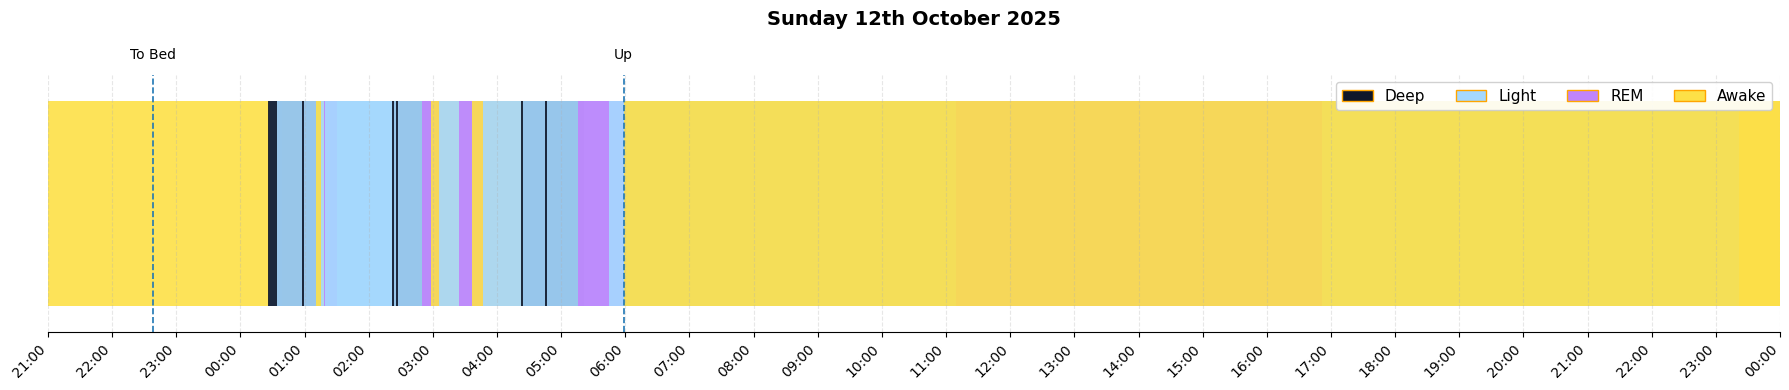


👟 Hourly Steps Distribution
----------------------------------------------------------------------


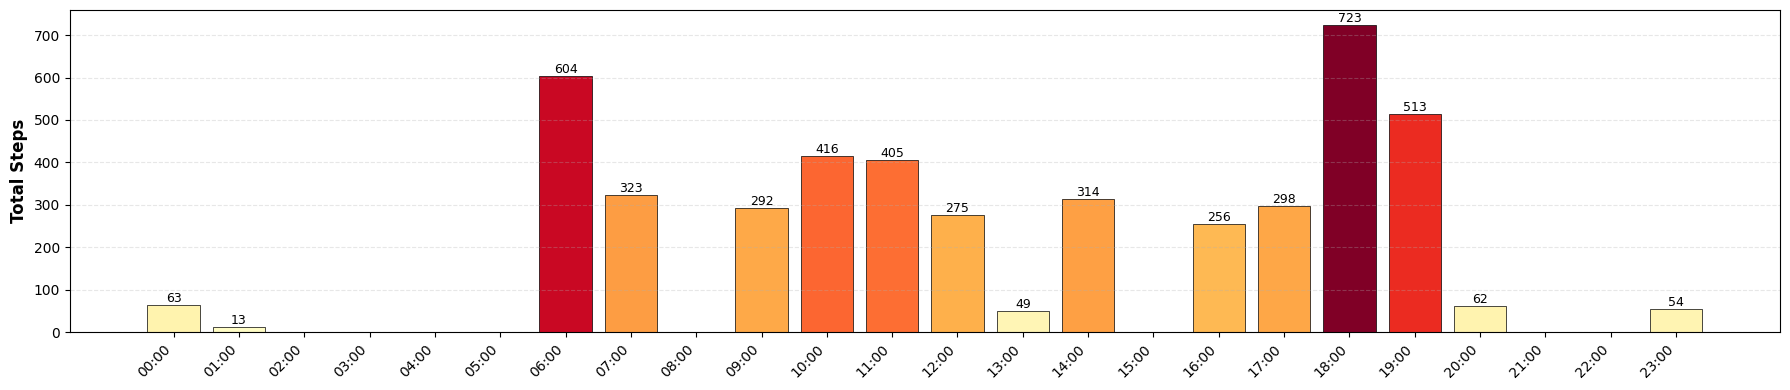

In [37]:
if ANALYSIS_MODE == 'single':
    # print(f"\n{'='*70}")
    # print(f"SINGLE-DAY SLEEP ANALYSIS FOR {TARGET_DATE}")
    # print(f"{'='*70}\n")
    
    # Main Sleep Timeline
    if not df_sleep_levels.empty and not df_sleep_summary.empty:
        print("\n🌙 Main Sleep Timeline")
        print("-" * 70)
        fig = plot_sleep_timeline(df_sleep_levels, df_sleep_summary)
        if fig: plt.show()

    # Hourly Steps Distribution
    if not df_steps_intra.empty:
        print("\n👟 Hourly Steps Distribution")
        print("-" * 70)
        fig = plot_hourly_activity_heatmap(df_steps_intra, TIMEZONE)
        if fig: plt.show()
    else:
        print("⚠️  No steps data available for hourly activity heatmap")

In [38]:
def plot_naps_timeline(df_levels, df_summary):
    """Plot individual timelines for all naps."""
    # if df_summary.empty:
    #     print(f"❌ No sleep summary found")
    #     return None

    # if 'isMainSleep' not in df_summary.columns:
    #     print(f"❌ No isMainSleep column found")
    #     return None

    naps = df_summary[df_summary['isMainSleep'] == 'False'].copy()

    if naps.empty:
        print(f"😴 No naps found")
        return None

    # Sort naps by time (earliest first)
    naps = naps.sort_values('time').reset_index(drop=True)

    print(f"💤 Found {len(naps)} nap(s)\n")

    fig, axes = plt.subplots(len(naps), 1, figsize=(16, 3 * len(naps)))
    if len(naps) == 1:
        axes = [axes]

    for idx, (nap_idx, nap) in enumerate(naps.iterrows()):
        ax = axes[idx]

        start_time = nap['time'] - pd.Timedelta(minutes=30)
        end_time = nap['end_time'] + pd.Timedelta(minutes=30)

        levels = prepare_sleep_data(df_levels, df_summary, start_time, end_time)

        if levels.empty:
            ax.text(0.5, 0.5, 'No detailed stage data available',
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title(f'Nap {idx+1} - No Data', fontweight='bold')
            continue

        plot_sleep_bars(ax, levels)

        nap_duration = nap['minutesInBed']
        nap_asleep = nap['minutesAsleep']
        efficiency = nap.get('efficiency', 0)

        # Main title for the figure
        fig.suptitle(f'{naps.iloc[0]["time"].strftime("%A %dth %B %Y")}', 
                     fontsize=16, fontweight='bold', y=1)
        
        # Each subplot title:
        title = (f'Nap {idx+1} - {nap["time"].strftime("%H:%M")} to {nap["end_time"].strftime("%H:%M")} | '
                 f'Duration: {nap_duration:.0f} min | Asleep: {nap_asleep:.0f} min')

        format_timeline_axis(ax, start_time, end_time, title, interval_minutes=15)

        if idx == 0:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, frameon=False)

    plt.tight_layout()
    return fig

In [39]:
if ANALYSIS_MODE == 'single':
    if not df_sleep_levels.empty and not df_sleep_summary.empty:
        print("\n💤 Nap Analysis")
        print("-" * 70)
        fig = plot_naps_timeline(df_sleep_levels, df_sleep_summary)
        if fig: plt.show()


💤 Nap Analysis
----------------------------------------------------------------------
😴 No naps found


In [40]:
def plot_sleep_stages_pie(df_levels, df_summary):
    """Plot pie chart showing sleep stage distribution."""
    summary = get_main_sleep_session(df_summary)
    if summary is None:
        print(f"❌ No sleep summary found")
        return None
    
    # Use wake-up date (end_time) for consistency with midnight-to-midnight approach
    end_time = summary.get('end_time') or summary.get('endTime')
    if end_time is not None:
        if isinstance(end_time, str):
            end_time = pd.to_datetime(end_time)
        sleep_date = end_time.tz_convert(TIMEZONE).date()
    else:
        # Fallback to start time if end_time not available
        start_time = summary['time'].tz_convert(TIMEZONE)
        sleep_date = start_time.date()
    
    stage_minutes = {
        'Deep': summary.get('minutesDeep', 0),
        'Light': summary.get('minutesLight', 0),
        'REM': summary.get('minutesREM', 0),
        'Awake': summary.get('minutesAwake', 0)
    }
    
    stage_minutes = pd.Series(stage_minutes)
    non_awake = stage_minutes.sum() - stage_minutes.get('Awake', 0)
    
    # Convert to hours and minutes
    def mins_to_hm(total_mins):
        hours = int(total_mins // 60)
        mins = int(total_mins % 60)
        return f'{hours}h {mins}m'
    
    time_in_bed = summary['minutesInBed']
    time_asleep = non_awake
    
    fig, ax = plt.subplots(figsize=(8, 8))
    colors_ordered = [SLEEP_COLORS[stage] for stage in stage_minutes.index]
    
    wedges, texts, autotexts = ax.pie(
        stage_minutes,
        labels=[f'{stage}\n{mins_to_hm(mins)}' for stage, mins in stage_minutes.items()],
        autopct='%1.1f%%',
        colors=colors_ordered,
        startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'},
        explode=[0.05] * len(stage_minutes)
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(14)
    
    ax.set_title(
        # f'{sleep_date.strftime("%A %dth %B %Y")}\n\n'
        f'Time in Bed: {mins_to_hm(time_in_bed)}\n'
        f'Time Asleep: {mins_to_hm(time_asleep)}',
        fontsize=14,
        fontweight='bold',
        pad=10
    )
    
    plt.tight_layout()
    return fig


📊 Main Sleep Composition
----------------------------------------------------------------------


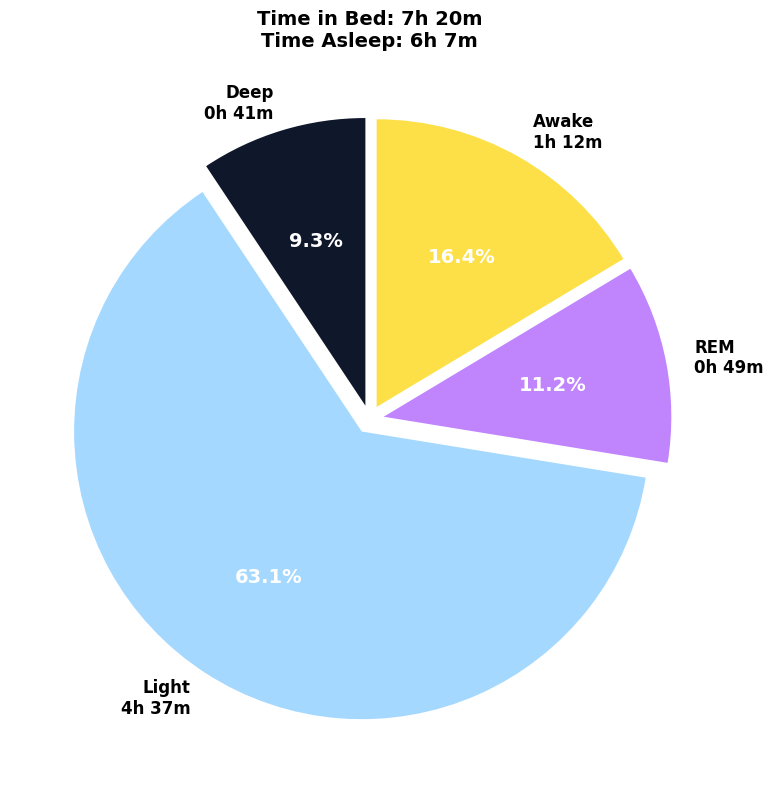

In [41]:
if ANALYSIS_MODE == 'single':
    if not df_sleep_summary.empty:
        print("\n📊 Main Sleep Composition")
        print("-" * 70)
        fig = plot_sleep_stages_pie(df_sleep_levels, df_sleep_summary)
        if fig: plt.show()

In [42]:
# ============================================================================
# MULTI-DAY SLEEP TRENDS
# ============================================================================

def plot_multi_day_sleep_timeline(df_sleep_levels, df_sleep_summary, start_date, end_date):
    """
    Plot state timeline for multiple days showing both main sleeps and naps.
    Each day gets its own row in the timeline.
    """
    if df_sleep_levels.empty or df_sleep_summary.empty:
        print("❌ No sleep data found")
        return None

    # Generate date range
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    num_days = len(dates)

    # Create figure with one row per day
    fig, axes = plt.subplots(num_days, 1, figsize=(18, 3 * num_days), sharex=False)
    if num_days == 1:
        axes = [axes]

    for idx, date in enumerate(dates):
        ax = axes[idx]
        date_str = date.strftime('%Y-%m-%d')

        # Define 24-hour window for this date (midnight to midnight)
        start_time = pd.Timestamp(date, tz=TIMEZONE)
        end_time = start_time + pd.Timedelta(days=1)

        # Get all sleep sessions for this date (main + naps)
        # Filter summary to get sessions that overlap with this day
        summary_for_day = df_sleep_summary.copy()
        summary_for_day['time'] = pd.to_datetime(summary_for_day['time']).dt.tz_convert(TIMEZONE)
        summary_for_day['end_time'] = pd.to_datetime(summary_for_day['end_time']).dt.tz_convert(TIMEZONE)

        # Get sessions that overlap with this day's window
        sessions = summary_for_day[
            (summary_for_day['time'] < end_time) &
            (summary_for_day['end_time'] > start_time)
        ]

        if sessions.empty:
            # No sleep data for this day
            ax.text(0.5, 0.5, 'No sleep data',
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=12, style='italic', color='gray')
            ax.set_xlim(start_time, end_time)
            ax.set_ylim(-0.5, 0.5)
            ax.set_yticks([])
            title = f'{date.strftime("%A, %B %d, %Y")} - No Data'
            ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            continue

        # Prepare sleep level data for this time window
        levels = prepare_sleep_data(df_sleep_levels, df_sleep_summary, start_time, end_time)

        if not levels.empty:
            plot_sleep_bars(ax, levels)

        # Add labels for each sleep session
        for _, session in sessions.iterrows():
            session_start = session['time']
            session_end = session['end_time']
            is_main = session.get('isMainSleep', 'True') == 'True'

            # Clip times to the current day's window for visualization
            display_start = max(session_start, start_time)
            display_end = min(session_end, end_time)

            label_text = "Main Sleep" if is_main else "Nap"
            duration_min = session.get('minutesInBed', 0)
            # efficiency = session.get('efficiency', 0)

            # Add vertical line at start
            ax.axvline(display_start, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

            # Add label above the timeline
            label_y_pos = 1.1
            ax.text(display_start, label_y_pos,
                   f"{label_text}\n{display_start.strftime('%H:%M')} | {duration_min:.0f}min\n\n",
                   ha='left', va='bottom', fontsize=9, fontweight='bold',
                   transform=ax.get_xaxis_transform())

        # Format the axis for this day
        formatter = DateFormatter('%H:%M', tz=TIMEZONE)
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(HourLocator(interval=2, tz=TIMEZONE))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

        ax.set_xlim(start_time, end_time)
        ax.set_ylim(-0.5, 0.5)
        ax.set_yticks([])
        # ax.set_xlabel('Time', fontsize=10, fontweight='bold')

        # Build title with session count
        main_count = len(sessions[sessions.get('isMainSleep', 'True') == 'True'])
        nap_count = len(sessions[sessions.get('isMainSleep', 'True') == 'False'])

        title_parts = [date.strftime("%A, %B %d, %Y")]
        if main_count > 0:
            title_parts.append(f"{main_count} main sleep")
        if nap_count > 0:
            title_parts.append(f"{nap_count} nap{'s' if nap_count > 1 else ''}")

        title = " - ".join(title_parts)
        ax.set_title(title, fontsize=12, fontweight='bold', pad=10)

        ax.grid(True, axis='x', alpha=0.6, linestyle='--')
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Add legend only on first plot
        if idx == 0:
            add_sleep_legend(ax, location='upper right')

    plt.suptitle(f'Multi-Day Sleep Timeline: {start_date} to {end_date}',
                fontsize=16, fontweight='bold', y=0.998)
    plt.tight_layout()

    return fig

print("✅ Multi-day analysis and activity pattern functions defined")

✅ Multi-day analysis and activity pattern functions defined


In [43]:
if ANALYSIS_MODE == 'multi':
    print(f"\n{'='*70}")
    print(f"MULTI-DAY SLEEP ANALYSIS: {START_DATE} to {END_DATE}")
    print(f"{'='*70}\n")
    
    # Multi-Day Sleep Timeline (Main Sleeps + Naps)
    if not df_sleep_levels.empty and not df_sleep_summary.empty:
        # print("\n🌙 Multi-Day Sleep State Timeline")
        # print("-" * 70)
        # print("Shows all sleep sessions (main sleeps and naps) across multiple days\n")
        fig = plot_multi_day_sleep_timeline(df_sleep_levels, df_sleep_summary, START_DATE, END_DATE)
        if fig: plt.show()
    else:
        print("❌ Insufficient data for multi-day timeline")

else:
    print("ℹ️  Multi-day analysis skipped (mode is 'single')")

ℹ️  Multi-day analysis skipped (mode is 'single')
